# Shor's Algorithm
---



Author: Alejandro Mata Ali

This notebook will implement Shor's algorithm using Quantum Phase Estimation with QFT (QPEwQFT) and using Iterative Quantum Phase Estimation (IQPE).

The basic paper that is followed in the creation of gates is: https://arxiv.org/abs/quant-ph/0205095, by Stéphane Beauregard.[1]

An explanation of Shor's algorithm: https://hmong.es/wiki/Shor%27s_algorithm [2]

Explanation of the IQPE: 
https://doi.org/10.48550/arXiv.quant-ph/0001066 [3]

Explanation author's seminar: https://youtu.be/AJqLk4-tzcc

---
Shor's algorithm is an algorithm for factoring the number $N = p \cdot q$ into the prime numbers $p$ and $q$ in polynomial time using quantum computing techniques.

The algorithm proceeds as follows:

### **Classical part**.

* Choose a random number $a$ between $2$ and $N-1$.
* Calculate $gcd(a, N)$ (greatest common divisor).
If $gcd(a, N) \neq 1$, this number is a non-trivial factor of $N$ and we are done.
* If $gcd(a, N) = 1$, we use the quantum part to find $r$, the period of the function: 
$f(x)=a^{x}{\bmod {N}}$.
* This $r$ is the smallest positive integer $r$ for which $f(x+r)=f(x)$.
* If $r$ is odd, we go back to step 1 (because we need its half).
* If $a^{r/2} = -1({\bmod {N}})$, we go back to step 1.
Otherwise, both $gcd(a^{r/2}+1,N)$ and $gcd(a^{r/2}-1,N)$ are non-trivial factors of $N$, the primes we want.

### **Quantum Part**

There are 2 possibilities which we will study later, but conceptually it is based on studying the eigenvalues of the operator $U_a$ which converts $|x\rangle$ into $|(a\cdot x)mod(N)\rangle$. This unitary operator introduces a phase in these states, which we can measure with quantum phase estimation methods and allows us to obtain the periodicity of the function $f(y)=a^{y}{bmod {N}}$.

The idea is that we are going to calculate with a superposition of states that we will interweave with the self-state.

Since we are going to study $f(y)=a^{y}{\bmod {N}}$, we will make the input state $|1\rangle$, since it is the self-state of this operator.

---
### Packages.

The packages we will need are the following:
* numpy (1.21.5): basic library for certain constants such as $\pi$ or functions for calculating binary numbers (floor and log2).
* pandas (1.4.2): library for processing results in tabular form to improve analysis.
* matplotlib.pyplot (3.5.1): package for graphing.
* qat.lang.AQASM (2.1.3): module for the creation and execution of quantum circuits.
* qat.qpus : package to obtain the qpu.
* QQuantLib: the modules phase_estimation_wqft and iterative_quantum_pe from the PhaseEstimation package, and solver and data_extracting from the Utils package of this library. It can be found at the GitHub link https://github.com/NEASQC/FinancialApplications.

In [1]:
#Visualisation and calculation.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Quantum
from qat.lang.AQASM import *
from qat.qpus import get_default_qpu
#External library to perform the QFT
from QQuantLib.PE.phase_estimation_wqft import PhaseEstimationwQFT
from QQuantLib.PE.iterative_quantum_pe import IterativeQuantumPE
from QQuantLib.utils.data_extracting import get_results

Username:  tec_app3
 ··········


In [2]:
#Package for the first connection.
#from qat.qlmaas import QLMaaSConnection
#conn = QLMaaSConnection(hostname="10.120.6.44", check_host=False)
#conn.create_config()

In this cell we declare which QLM resolver we are going to use:
* QLMaaS == False -> PyLinalg
* QLMaaS == True -> Try to use LinAlg (To use QPU as the CESGA QLM)

In [2]:
from QQuantLib.utils.qlm_solver import get_qpu
QLMaaS = True
linalg_qpu = get_qpu(QLMaaS)#This line acquires the resolver we have specified.

Using: LinAlg


---
# Puertas.

Here we will implement the necessary gates to generate Shor's gate.

The main goal is to get a gate $U_a$ such that:
$$U_a|x\rangle = |(a\cdot x)mod (N)\rangle$$

To do so, we will follow the entire procedure of the paper [1].

First we will define each gate, then we will visualise it and finally we will explain how it works.

We will start with the auxiliary functions for dealing with binary numbers and for modular algebra.

In [3]:
def numbin(a, n):
    '''Function that converts the decimal number a to a binary number with n bits.
    
    Parameters:
    a : integer that we want to convert to binary.
    n : integer of the number of bits we want for binary.
    '''
    a = format( a, 'b' )     #We convert the number to binary
    return '0'*(n-len(a)) + a#We add the necessary leading zeros to make it have the number of bits.

def m_inv(a, N):
    '''Function that implements the inverse module of N.'''
    for _ in range(1, N):                          #We go through all the numbers between 1 and N.
        if ((a%N) * (_%N)) % N == 1: return _      #If it is the inverse, we return the result and we are done.
    raise Exception('The inverse modulo does not exist.')# In case there is no such number.

## $\phi ADD(a)$

The first gate we are going to implement is the gate $\phi ADD(a)$, that transforms  $|\phi(b)\rangle$  into  $|\phi(b+a)\rangle$.

In [4]:
@build_gate('ADD', [int, str], arity=lambda n, a: n)
def add_g(n, a):
    '''Implementation of the phiADD(a) gate with n qbits.
    phi(b) -> phi(b+a)
    a is the binary of the number to implement.'''
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    b = routine.new_wires(n)#Input lines.
    
    #-------------------------------------
    #We run the addition.
    for i in range(n):#Target
        angle = sum( np.array( [ int(a[j])/2**(j-i) for j in range(i, n) ] ) )
        if angle != 0: routine.apply( PH(np.pi*angle), b[i] )
    
    return routine

In [5]:
gate = add_g(4, numbin(6, 4))
%qatdisplay gate --depth 1 --svg

The operation of this gate is as follows:

* The input that the gate receives will be the quantum Fourier transform of the number $b$ ( $\phi(b)$ ), and its output will be $\phi(b+a)$.
* Its input parameter will be the number $a$ that we want to use in binary format with n bits. It is important that it has the same number of bits as the input $\phi(b)$, since a 1 to 1 relationship is established between them.

* We create a group of rings for the number a and initialise them (with X gates) to be the state $|a_0 a_1 \dots a_{n-2} a_{n-1}\rangle$ with the $a_k$ being those that satisfy  $a = \sum_{k=0}^{n-1} a_k 2^{n-1-k}$.

Why do we use the quantum Fourier transform?

This is because in the transformed space, the phases over the states are sums over the standard space. Therefore, adding a phase in  $\phi(b)$ is the same as adding a number in $b$.

* After that, we apply controlled phase gates on the $|\phi_i\rangle$ qbit. We add controls from the $|a_j\rangle$ with $j \geq i$ with a phase $\frac{\pi}{2^{j-i}}$. (One way to save the anchors and controls is to use an if, since it is a classical number that enters as a parameter).

* Finally we reset the anchors and we have the state $|\phi(b+a)\rangle$.

## Addmod

The second gate we are going to implement is the gate $\phi ADD(a)mod(N)$, that transforms  $|\phi(b)\rangle$  into  $|\phi(b+a)mod(N)\rangle$.

In [5]:
@build_gate('ADDmod', [int, str, str], arity=lambda n, a, N: n)
def addmod_g(n, a, N):
    '''Implementation of the phiADD(a)mod(N) gate with n qbits.
    phi(b) -> phi((b+a)mod(N))
    a and N are the binary numbers to be implemented.'''
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    b  = routine.new_wires(n)#Input lines.
    a0 = routine.new_wires(1); routine.set_ancillae(a0)#Control ancilla of the most significant bit.
    
    #-------------------------------------
    #We apply the algorithm:
    #Add a, subtract N, QFT-1, we take out the most significant, QFT, add N
    routine.apply(add_g(n, a), b)
    
    routine.apply(add_g(n, N).dag(), b)
    routine.apply(qftarith.QFT(n).dag(), b)
    routine.apply(CNOT, b[0], a0)
    routine.apply(qftarith.QFT(n), b)
    routine.apply(add_g(n, N).ctrl(), a0, b)
    
    
    #-------------------------------------
    #Subtract a, QFT-1, significant, QFT, sum a
    routine.apply(add_g(n, a).dag(), b)
    
    routine.apply(qftarith.QFT(n).dag(), b)
    routine.apply(X, b[0]); routine.apply(CNOT, b[0], a0); routine.apply(X, b[0])
    routine.apply(qftarith.QFT(n), b)
    
    routine.apply(add_g(n, a), b)
    
    return routine

In [7]:
gate = addmod_g(4, numbin(7, 4), numbin(21, 4))
%qatdisplay gate --depth 1 --svg

This gate works according to the following logic:
* The input will be the quantum Fourier transform of the number $b$ ( $\phi(b)$ ), and its output will be $\phi(b+a) mod(N)$.
* Its parameters will be $a$ and $N$ in binary. The number $b$ must have an extra bit to avoid overflow and to be able to know which is the sign of intermediate counts.
* First we add $a$ having $\phi(b+a)$ and we proceed to subtract $N$ with the inverse (dagger) of $\phi ADD(N)$, obtaining $\phi(b+a-N)$.
* Now, after this last operation there is the possibility that the number obtained is negative, if $a+b\leq N$, so we will look at the most significant bit (the 0), for which we will first have to invert the QFT.
* As we need to use that bit later, we store it in a ring with a CNOT gate and redo the QFT to continue operating.
* Once this is done, if our number was negative, we need to undo the subtraction of $N$, as we do not want negative numbers, so using the ring where we put the sign information, we will apply the addition of $N$ in a way controlled by this qbit.

* In principle we already have $\phi(b+a) mod(N)$, but we need to restore the ancilla, so we need to know if we have subtracted $N$ before.
* To do this we will subtract $a$ and undo the QFT, which will give us the number $(a+b)mod N-a$ from which we will get the sign, but inverted. This is because we use the identity: $(a+b)mod(N)\geq a \rightarrow (a+b)mod(N)- a \Longleftrightarrow a + b < N$. Therefore, if the number obtained is positive, it will be because we obtained a negative number before.
* Therefore, we apply an X on that qbit, CNOT from that qbit to the ancilla, undo the X, go back to QFT and add back the $a$ we had subtracted.

## CMULT

The third gate that we are going to implement is the gate $\phi CMULT(a)mod(N)$, which transforms  $|x\rangle|\phi(b)\rangle$  into  $|x\rangle|\phi(b+a\cdot x)mod(N)\rangle$.

In [6]:
@build_gate('CMULT', [int, str, str], arity=lambda n, a, N: 2*n )
def cmult_g(n, a, N):
    '''Implementation of the phiCMULT(a)mod(N) gate with n qbits.
    b -> (b+a*x)mod(N)
    a and N are the binary of the number to implement.
    Enter X first and then b'''
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    x = routine.new_wires(n)#Input x (first).
    b = routine.new_wires(n)#Input b (second).
    
    #-------------------------------------
    #Transform, set of sums, Antitransform.
    routine.apply(qftarith.QFT(n), b)
    #We start at 0 (most significant) and work our way down.
    for i in range(0, n):#Control.
        for j in range(0, int(2**i)):#Number of applications.
            routine.apply( addmod_g(n, a, N).ctrl(), x[-i-1], b )
    routine.apply(qftarith.QFT(n).dag(), b)
    
    return routine

In [9]:
gate = cmult_g(3, numbin(3, 3), numbin(2, 3))
%qatdisplay gate --depth 1 --svg

This gate operates as follows:
* Its goal is to convert $b$ into $(b+a0dot x)mod(N)$, having as inputs $|xrangle$ and $|brangle$ and parameters $a$ and $N$ in binary form. It is important that $|x\rangle$ has the same number of qbits as $|brangle$, because of the following gate.
* The first thing we do is to transform the number $b$ into its QFT form. After that, we apply $\phi ADD(2^j a)mod(N)$ gates on $|\phi(b)\rangle$ controlled by the qbits $|x_{n-1-j}\rangle$. The $\phi ADD(2^j a)mod(N)$ gate means applying $2^j$ times the $\phi ADD(a)mod(N)$ gate.
* This step is exactly the same as the usual multiplication with binary numbers.
* After that we undo the QFT and we have our result.

Recall that we use the input numbers in standard space only in this gate, while the ones inside it use the numbers in transformed space. This is because if we were to introduce the QFTs into these gates as well, we would have something of the form:

$QFT-ADD-QFT_{inv}-QFT-ADD-QFT_{inv}-\dots-QFT-ADD-QFT_{inv}-QFT-ADD-QFT_{inv}$,

where obviously the QFTs disappear with their inverses, so we can save all those gates.

## Ua

Finally, we implemented the general gate $U_a$ that converts us $|x\rangle$ into $|(a\cdot x)mod(N)\rangle$.

In [11]:
@build_gate('U', [int, int, int], arity=lambda n, a, N: n)
def ua_g(n, a, N):
    '''Implementation of the phiCMULT(a)mod(N) gate with n qbits.
    x -> (a*x)mod(N)
    a and n are integers.'''
    #-------------------------------------
    #We prepare the parameters and the binaries.
    abin = numbin(a, n)
    ainv = numbin(m_inv(a, N), n)#a inverse modulo N
    Nbin = numbin(N, n)
    
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    x  = routine.new_wires(n)#Input line.
    a0 = routine.new_wires(n); routine.set_ancillae(a0)#Ancillas in 0.
    
    #-------------------------------------
    #We apply the algorithm:
    #Multiply, swap, divide.
    routine.apply(cmult_g(n, abin, Nbin), x+a0)
    for i in range(n): routine.apply(SWAP, x[i], a0[i])
    routine.apply(cmult_g(n, ainv, Nbin).dag(), x+a0)
    
    return routine

In [17]:
gate = ua_g(5, 7, 15)
%qatdisplay gate --depth 1 --svg

This Shor gate works as follows:
* This gate implements going from $x$ to $(a\cdot x)mod(N)$. Its input is the vector $|x\rangle$  and the parameters $a$ and $N$ in integer.
* We are going to use a ring initialised to 0 for the lower part of the multiplication (so the factor obtained will only be multiplied and will not have an addition).
* First we do the multiplication by a, obtaining $|x\rangle|(a\cdot x)mod(N)\rangle$.
* Since we don't want anything in the ancilla, we apply a SWAP between the ancilla and the main line, obtaining $|(a\cdot x)mod(N)\rangle|x\rangle$.
* Now we multiply by the inverse modulo $N$ of $a$ ($a^{-1}$) having $|(a\cdot x)\rangle|(x- a^{-1}a\cdot x)mod(N)\rangle = |(a\cdot x)mod(N)\rangle|0\rangle$, which is what we wanted.

---
# Shor's Algorithm.

Now that we have the gates implemented, we can perform Shor's algorithm. For this we will use the modules of the QQuantLib library.

The first thing we will have to do is to determine the values of the parameters $a$ and $N$ that we will have to use. We can use the ones we have or we can put 2 primes $q$ and $p$ and the following function already looks for a suitable $N$ and $a$.

In [8]:
def primador(p, q, itmax = 100, used_a = []):
    '''Function that implements the creation of a number N from 2 primes
    and gives us a valid number a for the algorithm.
    itmax is the number of iterations allowed to search for this a.'''
    N   = p * q
    ver = True; itera = 0      #Check that the greatest common divisor of a and N is 1.
    while ver and itera<itmax:
        a  = np.random.randint(2, N)#Random integer between 2 and N.
        cd = np.gcd(a, N)
        if cd == 1 and (a not in used_a): ver = False
        itera += 1#Iteration counter.
    if ver == True: print('No valid a has been found.')
    return a, N

def reductor(num, den):
    '''This function implements the obtaining of 
    the irreducible fraction of a number.
    The input number is to be a fraction num/den.
    Both parameters are integers.
    It is based on dividing by all possible values.'''
    for i in range(num, 0, -1):
        if num % i == 0 and den % i == 0:
            num /= i; den /= i
    return int(num), int(den)

In [14]:
#Prime numbers to build N.
p = 3
q = 7

#-------------------------------------
#Run the function or enter them by hand.
a, N = primador(p, q)
a = 7; N = 15; p = 3; q = 5
print('a = ', a, ', N = ', N)
#We determine the number of qbits.
n = 1 + int(np.floor(np.log2(N))); n +=1
n_cbits = n #Same for the classics.

a =  7 , N =  15


We create the initial conditions and the gate with our parameters.

We initialise $|x\rangle$ to 1 (00...001).

In [15]:
#Our Gate of Shor.
unitary_operator = ua_g(n, a, N)
#-------------------------------------
#Initial state.
initial_state = QRoutine()
x = initial_state.new_wires(n)
initial_state.apply(X, x[-1])#State 1.

We configure the method we are going to use.

In [16]:
#Python dictionary for configuration.
config_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : linalg_qpu,
    'auxiliar_qbits_number' : n_cbits,  
    'shots': 100
}

---
## Phase Estimation with QFT.

The first thing we can do is to use Phase Estimation with QFT.

With this algorithm we need $3n_a$ qbits, because we need n for our initial state $|1rangle$ and 2n for the register.

What we will do is introduce initialise the $2n_a$ register qbits with an H gate each, thus being in a superposition of $|0\rangle$ and $|1\rangle$. We then apply the $U_{a^{2^i}}$ gate controlled by the ith register qbit. This involves applying $2^i$ times the $U_{a}$ gate.

Finally an inverse quantum Fourier transform is performed to recover in each register qbit a phase and thus obtain our result m when measuring.

($n_a = n+1$)

In total we will use $4n+3$ qbits.

We create the function and send it to execute.

In [17]:
qft_pe = PhaseEstimationwQFT(**config_dict)
qft_pe.pe_wqft()#We send it to execute

Submitted a new batch: Job7653


We obtain the list of results of the algorithm with the numbers obtained with a frequency greater than 0, these results will be $y$.

We obtain $r$ as the denominator of the irreducible fraction of $\frac{y}{2^n}$ and we apply that $p = gcd(a^{r/2} - 1, N)$ and $q = gcd(a^{r/2} + 1, N)$ and we check.

In [30]:
Resultados = qft_pe.final_results.loc[qft_pe.final_results['Probability'] > 0]
Valores = np.sort([ _ for _ in Resultados['Int'] ])#Only the integers from smallest to largest.

for i in range(len(Valores)):#0 does not contribute.
    if Valores[i] != 0:
        r = reductor(Valores[i], 2**n)[1]#The denominator.
        if r % 2 == 0:
            if a**int(r/2) != -1 % N:
                p_obt = np.gcd(a**int(r/2) - 1, N);   q_obt = np.gcd(a**int(r/2) + 1, N)
                if (p == q_obt and q == p_obt) or (p == p_obt and q == q_obt):
                    print('r = ', r)
                    print('The primes are: ', p_obt, ', ', q_obt)
                    break
                else: print('Not satisfied. The primes obtained are: ', p_obt, q_obt)

r =  4
Los primos son:  3 ,  5


---
## Iterative Quantum Phase Estimation. [3]

Now we will use the Iterative Quantum Phase Estimation.

In this algorithm we will only need $n_a+1$ qbits, because we will only use one qbit to encode the result by partial measurements.

The procedure consists of the following:

* We have our control qbit at 0, apply an H-gate to obtain a superposition and apply the gate in a controlled way as before.
* The difference is that we now reapply the H-gate and make a partial measurement of the control qbit and store in a classical bit the result.
* We now apply a gate X controlled by the previous result (stored in the classical bit) to return our control qbit to 0.
* We repeat, do H and control the next gate (the same applied $2^i$ times), now do a phase rotation to return phase 0 to our state before applying H again and resetting the state with the controlled X.
* The question is how to do this phase rotation. Basically we will apply a phase rotation gate that is 'controlled' (actually parameterised) by the classical registers of the previous measurements. So we can know how much the state has been rotated by applying the $U_a$ operator k times.
* Thus, the value we will obtain in the classical register by means of the intermediate measurements will be the one we would obtain by means of the QPEwQFT.

We create the function and send it to execute.

In [23]:
iqpe_ = IterativeQuantumPE(**config_dict)
iqpe_.iqpe()

Submitted a new batch: Job7654


We histogram the results with their corresponding frequencies.

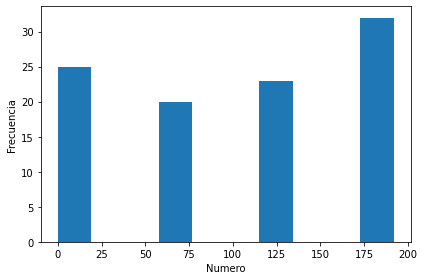

In [25]:
plt.xlabel('Numero'); plt.ylabel('Frecuencia')
plt.hist(iqpe_.final_results['BitInt'])
plt.tight_layout(); plt.show()

We obtain the list of results of the algorithm with the numbers obtained with a frequency greater than 0, these results will be $y$.

We obtain $r$ as the denominator of the irreducible fraction of $\frac{y}{2^{n+3}}$ and we apply that $p = gcd(a^{r/2} - 1, N)$ and $q = gcd(a^{r/2} + 1, N)$ and we check.
The +3 comes because the values are multiplied by 8.

In [33]:
Resultados = iqpe_.sumarize(iqpe_.final_results, 'BitInt')
Valores = np.sort([ _ for _ in Resultados['BitInt'] ])#Only the integers from smallest to largest.

for i in range(len(Valores)):#0 does not contribute.
    if Valores[i] != 0:
        r = reductor(Valores[i], 2**(n+3))[1]#The denominator.
        if r % 2 == 0:
            if a**int(r/2) != -1 % N:
                print('r = ', r)
                p_obt = np.gcd(a**int(r/2) - 1, N);   q_obt = np.gcd(a**int(r/2) + 1, N)
                if (p == q_obt and q == p_obt) or (p == p_obt and q == q_obt):
                    print('The primes are: ', p_obt, ', ', q_obt)
                    break
                else: print('Not satisfied. The primes obtained are: ', p_obt, q_obt)

r =  4
Los primos son:  3 ,  5


## Executable function.

To recapitulate, let's build a function that already implements the whole algorithm together. We will only have to give it the numbers p and q to form N.

In [9]:
def Shor(p, q, shots = 8, method = 'QPE', used_a = []):
    '''Function that implements all of Shor's algorithm for a given pair p, q of
    given integer primes. You can change the number of shots.
    method is the resolution method to use.
    If we set QPE it will use quantum phase estimation with QFT.
    If we put IQPE it will use the Iterative Quantum Phase Estimation.'''
    
    #-------------------------------------
    a, N = primador(p, q, used_a = used_a)
    print('a = ', a, ', N = ', N)
    #We determine the number of qbits.
    n = 2 + int(np.floor(np.log2(N)))
    n_cbits = n #Same for the classics.
    
    #Our Gate of Shor.
    unitary_operator = ua_g(n, a, N)
    #-------------------------------------
    #Initial state.
    initial_state = QRoutine()
    x = initial_state.new_wires(n)
    initial_state.apply(X, x[-1])#State 1.
    
    
    #Python dictionary for configuration.
    config_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : linalg_qpu,
    'auxiliar_qbits_number' : n_cbits,  
    'shots': shots
    }
    
    if method == 'QPE':
        qft_pe = PhaseEstimationwQFT(**config_dict)
        qft_pe.pe_wqft()#We send it to execute
        Resultados = qft_pe.final_results.loc[qft_pe.final_results['Probability'] > 0]
        Valores    = np.sort([ _ for _ in Resultados['Int'] ])#Only the integers from smallest to largest.
    
    elif method == 'IQPE':
        iqpe_ = IterativeQuantumPE(**config_dict)
        iqpe_.iqpe()
        Resultados = iqpe_.sumarize(iqpe_.final_results, 'BitInt')
        Valores    = np.sort([ _ for _ in Resultados['BitInt'] ])#Only the integers from smallest to largest.
    
    check = 0
    for i in range(len(Valores)):#0 does not contribute.
        if Valores[i] != 0:
            if method == 'QPE':  r = reductor(Valores[i], 2**n)[1]#The denominator.
            if method == 'IQPE': r = reductor(Valores[i], 2**(n+3))[1]#The denominator.
            if r % 2 == 0:
                if a**int(r/2) != -1 % N:
                    print('r = ', r)
                    p_obt = np.gcd(int(a**int(r/2) - 1), N);   q_obt = np.gcd(int(a**int(r/2) + 1), N)
                    if (p == q_obt and q == p_obt) or (p == p_obt and q == q_obt):
                        print('The primes are: ', p_obt, ', ', q_obt)
                        check = 1
                    else: print('Not satisfied. The primes obtained are: ', p_obt, q_obt)
    
    if check == 0: p_obt = 0; q_obt = 0; print('None found.')
        
    return Valores, p_obt, q_obt, check, a
        

We do some tests for different numbers.

In [10]:
Valores, p_obt, q_obt, check, a = Shor(3, 5, shots = 8, method = 'QPE', used_a =[1, 2,3,4,5,6,8,9,10,11,12,13,14,15])

a =  7 , N =  15
Submitted a new batch: Job7742
r =  4
Los primos son:  3 ,  5
r =  4
Los primos son:  3 ,  5


In [41]:
itera = 1; check = 0; it_max = 100
used_a = []
while check != 1 and itera < it_max:
    Valores, p_obt, q_obt, check, a = Shor(3, 7, shots = 8, method = 'QPE', used_a = used_a)
    used_a.append(a)
    itera += 1

a =  2 , N =  21
Submitted a new batch: Job7669
r =  64
No se cumple. Los primos obtenidos son:  3 1
r =  2
No se cumple. Los primos obtenidos son:  1 3
Ninguno encontrado.
a =  8 , N =  21
Submitted a new batch: Job7670
r =  2
Los primos son:  7 ,  3


In [43]:
itera = 1; check = 0; it_max = 100
used_a = [17, 31, 23, 3, 12, 34]
while check != 1 and itera < it_max:
    Valores, p_obt, q_obt, check, a = Shor(5, 7, shots = 8, method = 'QPE', used_a = used_a)
    used_a.append(a)
    itera += 1

a =  29 , N =  35
Submitted a new batch: Job7678
r =  2
Los primos son:  7 ,  5


In [14]:
itera = 1; check = 0; it_max = 100
used_a = [17, 38, 7, 44, 32]
while check != 1 and itera < it_max:
    Valores, p_obt, q_obt, check, a = Shor(5, 9, shots = 8, method = 'QPE', used_a = used_a)
    used_a.append(a)
    itera += 1

a =  38 , N =  45
Submitted a new batch: Job7691
r =  128
No se cumple. Los primos obtenidos son:  15 1
r =  4
No se cumple. Los primos obtenidos son:  3 5
r =  64
No se cumple. Los primos obtenidos son:  15 1
Ninguno encontrado.
a =  7 , N =  45
Submitted a new batch: Job7692
r =  128
No se cumple. Los primos obtenidos son:  15 1
r =  4
No se cumple. Los primos obtenidos son:  3 5
Ninguno encontrado.
a =  44 , N =  45
Submitted a new batch: Job7693
Ninguno encontrado.
a =  32 , N =  45
Submitted a new batch: Job7694
r =  128
No se cumple. Los primos obtenidos son:  15 1
r =  2
No se cumple. Los primos obtenidos son:  1 3
Ninguno encontrado.
a =  19 , N =  45
Submitted a new batch: Job7695
r =  2
Los primos son:  9 ,  5


In [15]:
itera = 1; check = 0; it_max = 100
used_a = []
while check != 1 and itera < it_max:
    Valores, p_obt, q_obt, check, a = Shor(3, 11, shots = 8, method = 'QPE', used_a = used_a)
    used_a.append(a)
    itera += 1

a =  10 , N =  33
Submitted a new batch: Job7696
r =  2
Los primos son:  3 ,  11


The algorithm works.

---
# Conclusions.

We have seen how to implement the different gates needed for Shor's algorithm, how to extract information using them and finally the last part of the algorithm.

Possible improvements to the system could be:

* Eliminate or reduce the last part of the gate $\phi ADD(a)mod(N)$, as it only serves to return the ancilla to the value 0. This could be done by some classically controlled process, but it could result in the gate no longer being invertible.
* Parallelise the IQPE to reduce the length of the sections (saving time and cumulative errors), bearing in mind that almost all the computational weight resides in the gates we apply.
* Optimise the different gates and their junctions.

In the Shor function we have implemented we require both numbers found to be prime, but in reality only one of them needs to be prime, which greatly reduces the number of queries.